# How to Hedge

Import relevant packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Use Panoptic stylesheet - replace with where you saved it on your local directory
plt.style.use('[Your filepath here]/stylesheet/panoptic-dark-2_1.mplstyle')

# Payoffs on UniV2

Try playing with different initial parameters (capital_0, S_0)!

In [2]:
# Initial parameters
capital_0 = 1_000 # Initial capital
S_0 = 1_000 # Initial price
fee_perc = 3
# We assume LPing in ETH-USDC pool, but this works for any asset pair!

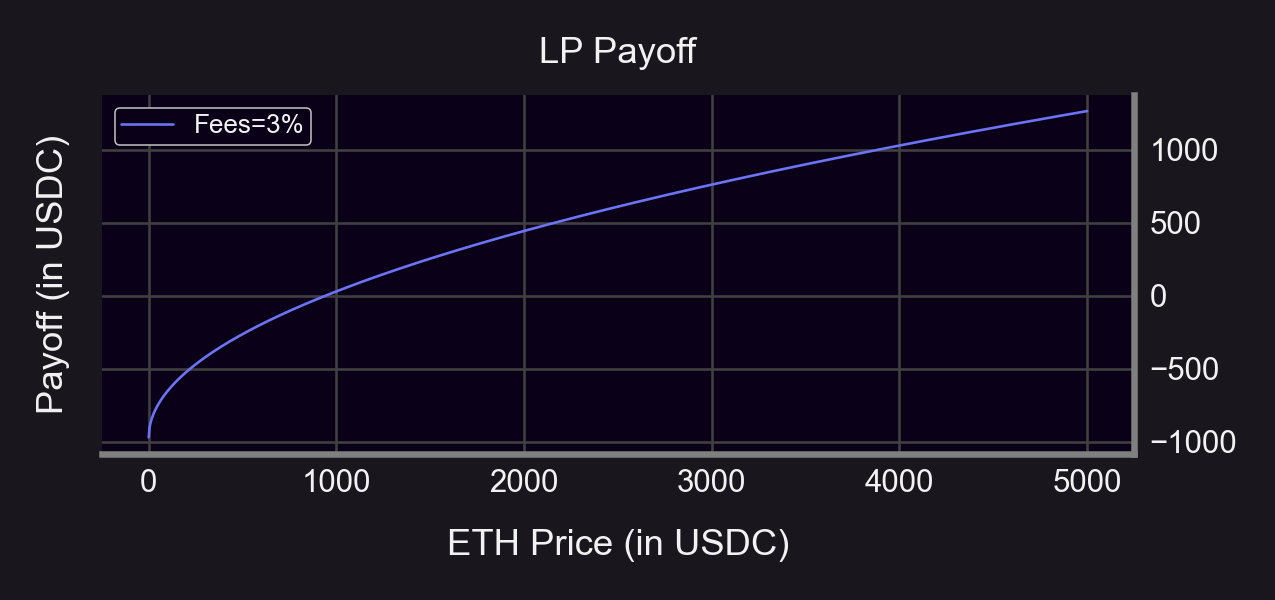

In [6]:
def LP_2(S: np.ndarray, S_0: float, capital_0: float, fee_perc: float) -> np.ndarray:
    """
    Calculates payoff for UniV2 LP

    :S (spot) price of token x in terms of token y
    :S_0 initial price of token x in terms of token y
    :capital_0 initial capital
    :fee_perc Fees collected (percent of initial capital) # This is an estimate of your earnings from LP
    """
    # Split 50/50 between tokens x and y
    x_0 = (capital_0 / S_0) / 2
    y_0 = capital_0 / 2
    
    fees = (fee_perc / 100) * capital_0
    L = np.sqrt(x_0 * y_0)
    payoff = 2 * L * (np.sqrt(S) - np.sqrt(S_0)) + fees
    return payoff


# Create range of spot prices to plot
spot_prices = np.linspace(0, S_0 * 5, 1000)
lp = LP_2(spot_prices, S_0, capital_0, fee_perc)

# Plot payoff
plt.plot(spot_prices, lp, label=f"Fees={fee_perc}%")
plt.xlabel('ETH Price (in USDC)')
plt.ylabel('Payoff (in USDC)')
plt.title('LP Payoff')
plt.legend()

# Payoffs on UniV3

Try playing with different initial parameters (capital_0, S_0)!

In [7]:
# Initial parameters
capital_0 = 1_000
S_0 = 1_000
fee_perc = 3
r = 1.3 # range factor
# We assume LPing in ETH-USDC pool, but this works for any asset pair!

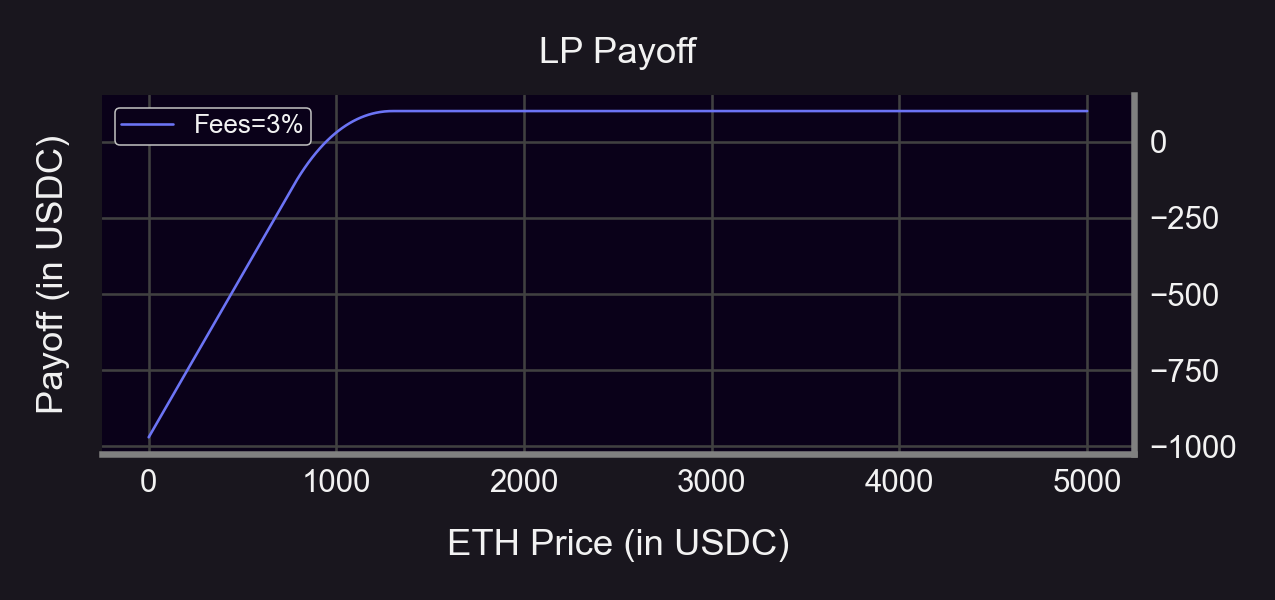

In [8]:
def LP_3(S: list, S_0: float, capital_0: float, fee_perc: float, r: float) -> float:
    """
    Calculates payoff for UniV3 LP
    Assumes LP +/- X% around S_0
    See https://lambert-guillaume.medium.com/how-to-deploy-delta-neutral-liquidity-in-uniswap-or-why-euler-finance-is-a-game-changer-for-lps-1d91efe1e8ac

    :S (spot) price of token x in terms of token y
    :S_0 initial price of token x in terms of token y
    :capital_0 initial capital
    :fee_perc Fees collected (percent of initial capital) # This is an estimate of your earnings from LP
    :r range factor (r=1.3 --> +/- 30% range)
    """
    # Split 50/50 between tokens x and y
    x_0 = (capital_0 / S_0) / 2
    y_0 = capital_0 / 2

    # Calculate position value based spot price (S)
    S_adj = np.clip(S, S_0 / r, S_0 * r) # ensures price used for calculating token amts d/n exceed price range
    # https://atiselsts.github.io/pdfs/uniswap-v3-liquidity-math.pdf
    L_x = x_0 * ((np.sqrt(S_0) * np.sqrt(S_0 * r)) / (np.sqrt(S_0 * r) - np.sqrt(S_0)))
    L_y = y_0 / (np.sqrt(S_0) - np.sqrt(S_0 / r))
    L = min(L_x, L_y)

    x_1 = L * (np.sqrt(S_0 * r) - np.sqrt(S_adj)) / (np.sqrt(S_adj) * np.sqrt(S_0 * r))
    y_1 = L * (np.sqrt(S_adj) - np.sqrt(S_0 / r))
    pos_1 = x_1 * S + y_1 # in token y
    
    # Calculate estimated fees earned
    fees = (fee_perc / 100) * capital_0

    payoff = pos_1 - capital_0 + fees
    return payoff

# Create range of spot prices to plot
spot_prices = np.linspace(0, S_0 * 5, 1_000)
lp = [LP_3(S, S_0, capital_0, fee_perc, r) for S in spot_prices]

# Plot payoff
plt.plot(spot_prices, lp, label=f"Fees={fee_perc}%")
plt.xlabel('ETH Price (in USDC)')
plt.ylabel('Payoff (in USDC)')
plt.title('LP Payoff')
plt.legend()

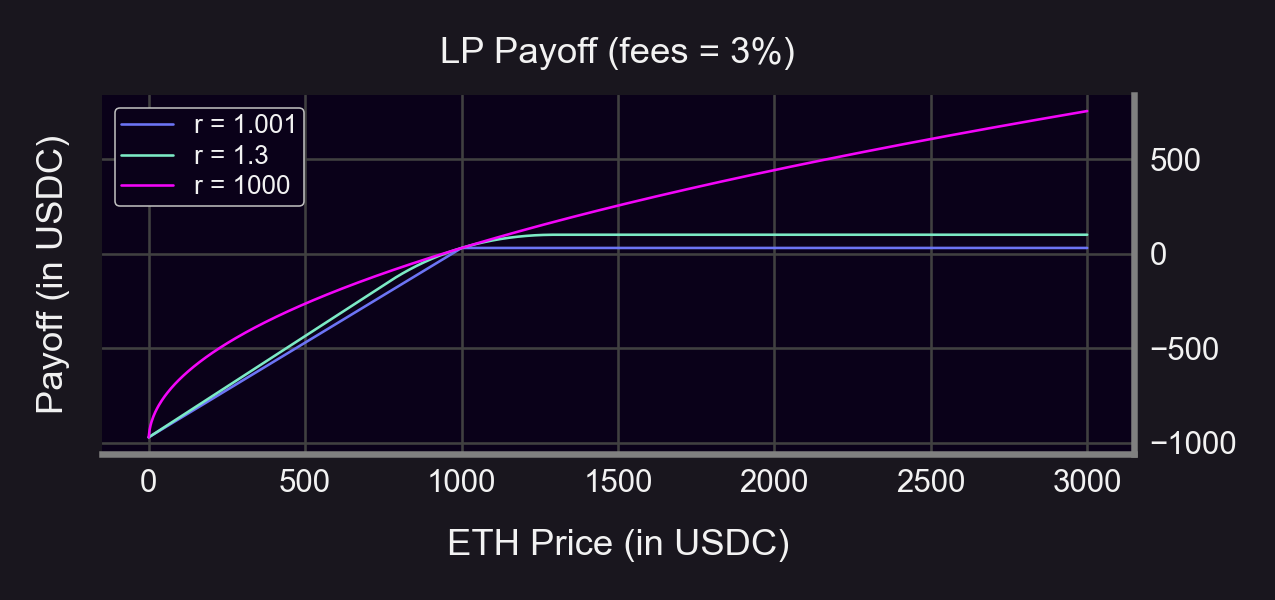

In [9]:
# Plot multiple range factors on same graph
range_factors = [1.001, 1.3, 1_000]

# Create range of spot prices to plot
spot_prices = np.linspace(0, S_0 * 3, 1_000)

for r in range_factors:
    lp = [LP_3(S, S_0, capital_0, fee_perc, r) for S in spot_prices]

    # Plot payoff
    plt.plot(spot_prices, lp, label=f"r = {r}")
    
plt.xlabel('ETH Price (in USDC)')
plt.ylabel('Payoff (in USDC)')
plt.title(f"LP Payoff (fees = {fee_perc}%)")
plt.legend()

# Inverse Payoff Curves

Try playing with different range factors (r)!

In [10]:
# Change these to whatever you like!
capital_0 = 1_000
S_0 = 1_000
fee_perc = 3
r = 1.3 # range factor
# We assume LPing in ETH-USDC pool, but this works for any asset pair!

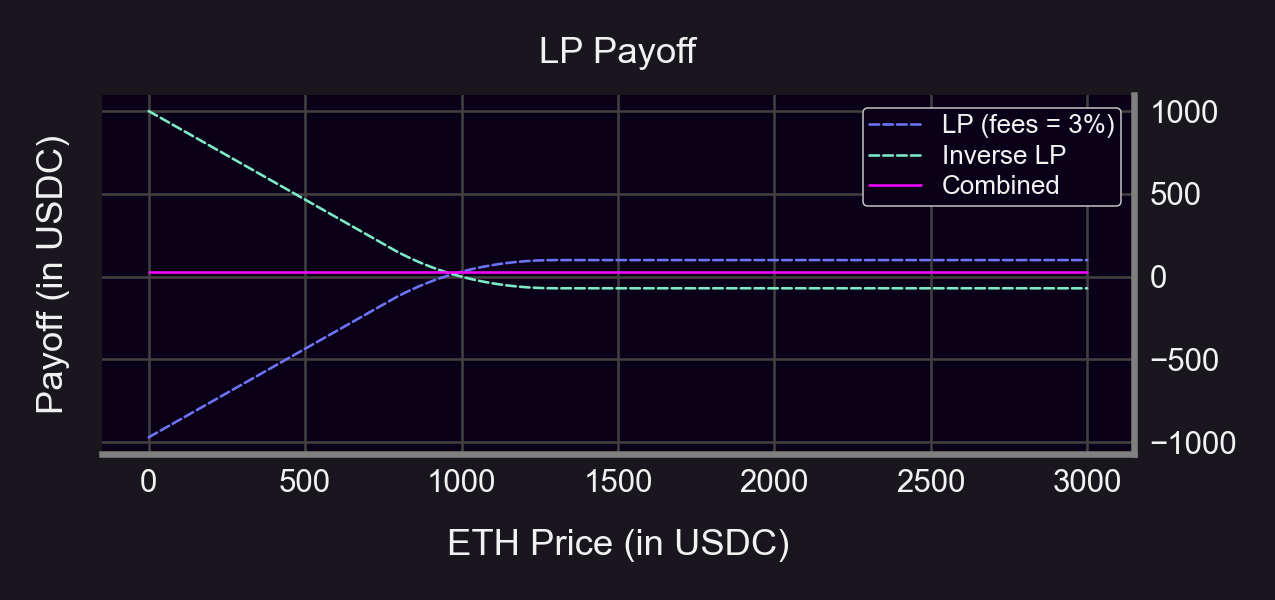

In [11]:
# Create range of spot prices to plot
spot_prices = np.linspace(0, S_0 * 3, 1_000)
lp = [LP_3(S, S_0, capital_0, fee_perc, r) for S in spot_prices]
inv_lp = [-LP_3(S, S_0, capital_0, 0, r) for S in spot_prices] # no fees
combined = [x + y for x, y in zip(lp, inv_lp)]

# Plot all
plt.plot(spot_prices, lp, linestyle='--', label=f"LP (fees = {fee_perc}%)")
plt.plot(spot_prices, inv_lp, linestyle='--', label="Inverse LP")
plt.plot(spot_prices, combined, label="Combined")
plt.xlabel('ETH Price (in USDC)')
plt.ylabel('Payoff (in USDC)')
plt.title('LP Payoff')
plt.legend()

# Constructing a hedge

Try playing with different initial parameters!

In [12]:
# Put option
S_0 = 1_000
X = S_0
P = 50

Text(0.5, 1.0, 'Long Put Option')

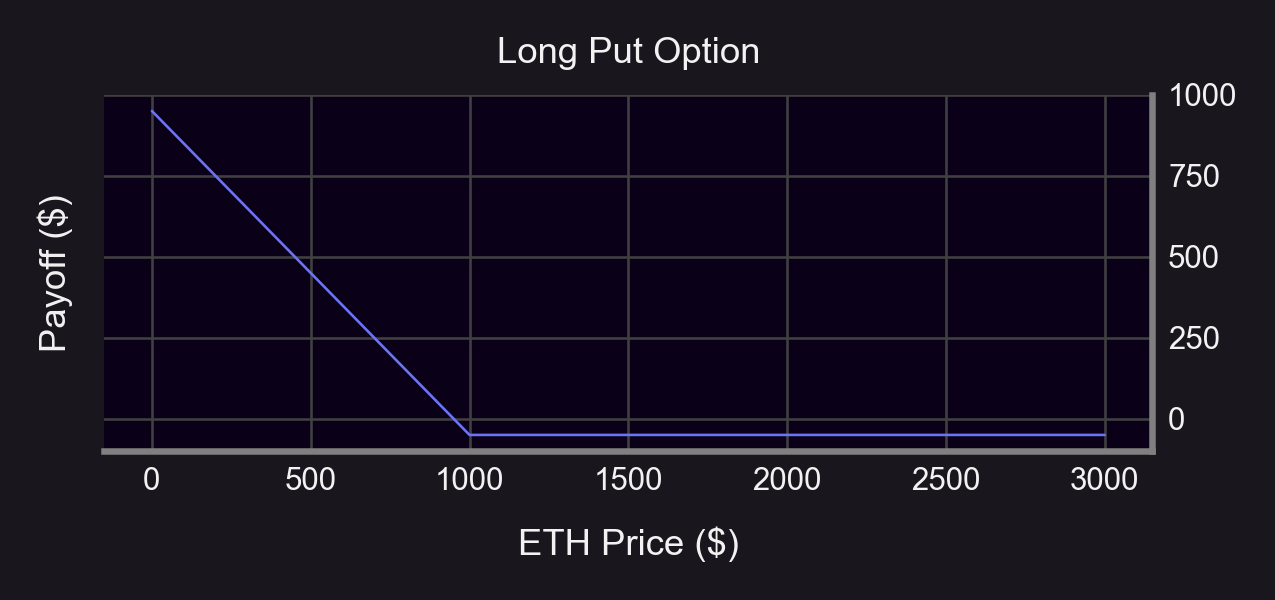

In [13]:
def put(S: np.ndarray, X: float, P: float) -> np.ndarray:
    """
    Calcaultes payoff for a call option

    :S Spot price
    :X Strike price
    :P Price (premium) of buying option
    """

    return np.where(S < X, X - S, 0) - P

spot_prices = np.linspace(0, S_0 * 3, 1_000)
payoff_put = put(spot_prices, X, P)

# Plot
plt.plot(spot_prices, payoff_put, label='Long Put')
plt.xlabel('ETH Price ($)')
plt.ylabel('Payoff ($)')
plt.title('Long Put Option')

In [15]:
# https://lambert-guillaume.medium.com/how-to-create-a-perpetual-options-in-uniswap-v3-3c40007ccf1
def calc_DTE(r: float, volatility: float = 1) -> float:
    """Calculates corresponding options DTE for a UniV3 range factor"""
    return 365 * (2 * np.pi / volatility ** 2) * ( (np.sqrt(r) - 1) / (np.sqrt(r) + 1) ) ** 2

print(f"A range factor of {r} corresponds to approximately {round(calc_DTE(1.3))} days")

A range factor of 1.3 corresponds to approximately 10 days


# Seeing how well our hedge does

Try playing with different option parameters!

In [16]:
# LP
capital_0 = 1_000
S_0 = 1_000
fee_perc = 3
r = 1.3 # range factor
# We assume LPing in ETH-USDC pool, but this works for any asset pair!

# Put option
S_0 = 1_000
X = S_0
P = 50
num_contracts = 1

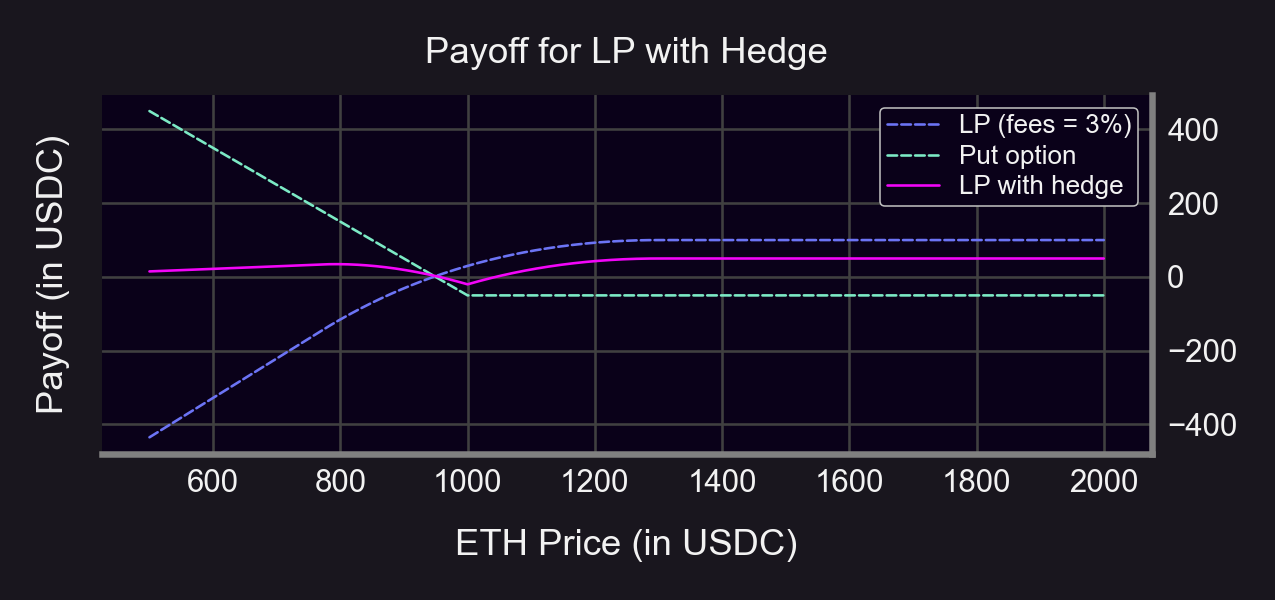

In [17]:
# Create range of spot prices to plot
spot_prices = np.linspace(S_0 / 2, S_0 * 2, 1_000)
lp = [LP_3(S, S_0, capital_0, fee_perc, r) for S in spot_prices]
payoff_put = put(spot_prices, X, P)
payoff_puts = [num_contracts * x for x in payoff_put]
combined = [x + y for x, y in zip(lp, payoff_puts)]

# Plot all
plt.plot(spot_prices, lp, linestyle='--', label=f"LP (fees = {fee_perc}%)")
plt.plot(spot_prices, payoff_puts, linestyle='--', label=f"Put option")
plt.plot(spot_prices, combined, label="LP with hedge")
plt.xlabel('ETH Price (in USDC)')
plt.ylabel('Payoff (in USDC)')
plt.title('Payoff for LP with Hedge')
plt.legend()

Calculate the delta of our position

In [18]:
delta = (np.sqrt(r) - 1) / (r - 1)
delta

0.46725141699712675

# Impermanent Loss

### IL on UniV2

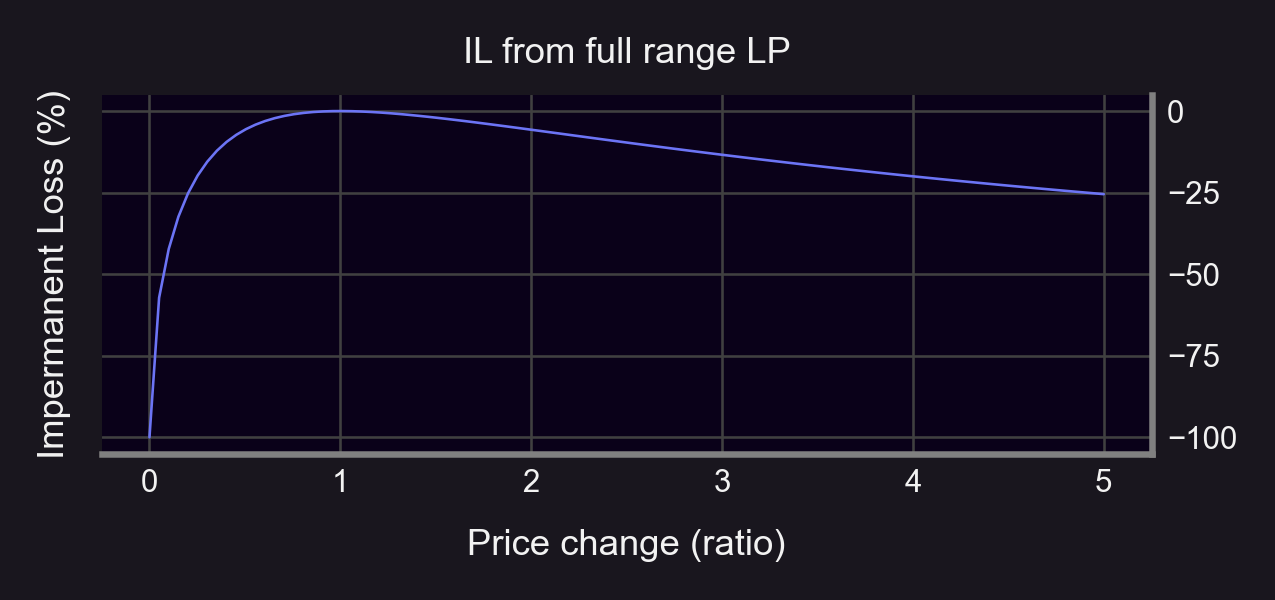

In [19]:
def IL_2(a: float) -> float:
    """
    Calculates impermanent loss for a change in price
    See https://medium.com/auditless/how-to-calculate-impermanent-loss-full-derivation-803e8b2497b7
    
    :a change-in-price ratio (a=2 means price doubled)
    """
    il = (2 * np.sqrt(a)) / (1 + a) - 1
    return il * 100

a = np.linspace(0, 5, 100)
il = IL_2(a)

plt.xlabel('Price change (ratio)')
plt.ylabel('Impermanent Loss (%)')
plt.title("IL from full range LP")

plt.plot(a, il)

### IL on UniV3
Try playing with different range factors (r)!

In [20]:
# Change r1, r2, r3, r4 to whatever you like!
r1 = 1_000
r2 = 2
r3 = 1.3
r4 = 1.01
# Notice that as r -> infinity, IL_v3 -> IL_v2

range_factors = [r1, r2, r3, r4]

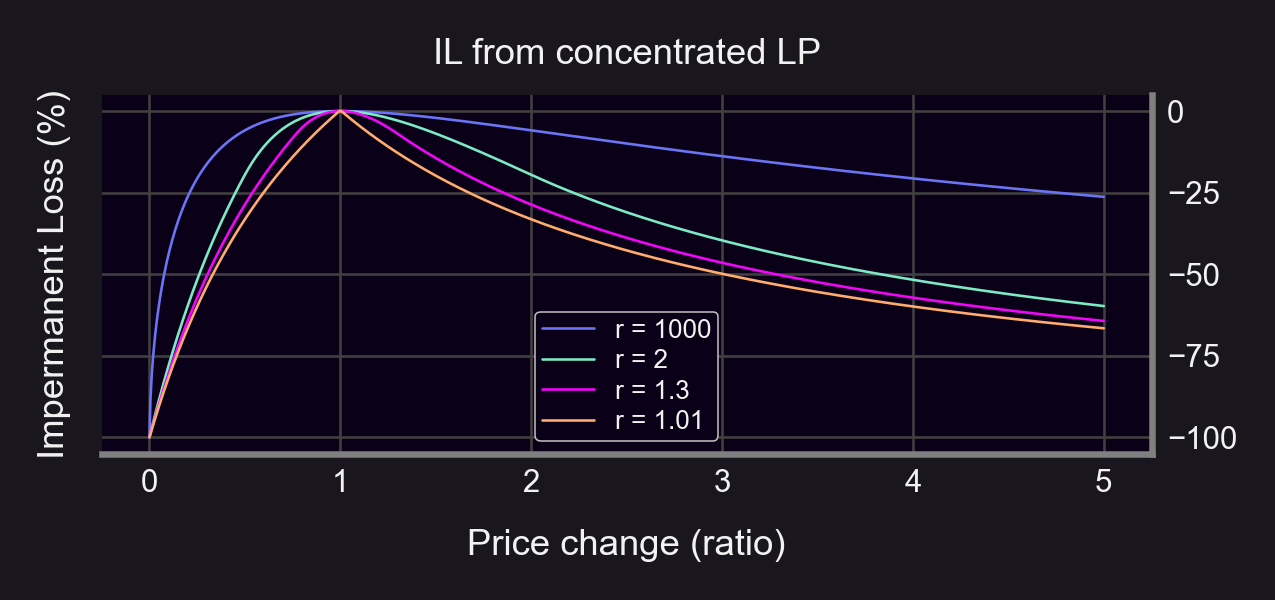

In [22]:
def IL_3(a: float, r: float) -> float:
    """
    Calculates impermanent loss for a change in price
    See https://lambert-guillaume.medium.com/an-analysis-of-the-expected-value-of-the-impermanent-loss-in-uniswap-bfbfebbefed2
    
    :a change-in-price ratio (a=2 means price doubled)
    :r range factor (r=1.3 means +/- 30% LP range)
    """
    if a < 1 / r:
        il = (np.sqrt(r) * a - 1) / (a + 1)
        il *= 100
    elif a < r:
        il = (np.sqrt(r) / (np.sqrt(r) - 1)) * IL_2(a)
    else:
        il = (np.sqrt(r) - a) / (a + 1)
        il *= 100
    return il

a = list(np.linspace(0, 5, 1000))
for r in range_factors:
    il = [IL_3(x, r) for x in a]
    plt.plot(a, il, label=f"r = {r}")

plt.xlabel('Price change (ratio)')
plt.ylabel('Impermanent Loss (%)')
plt.title("IL from concentrated LP")
plt.legend(loc="lower center")

# Inverse Loss Curves

Try playing with different range factors (r)!

In [23]:
# Change r to whatever you like!
r = 1.3

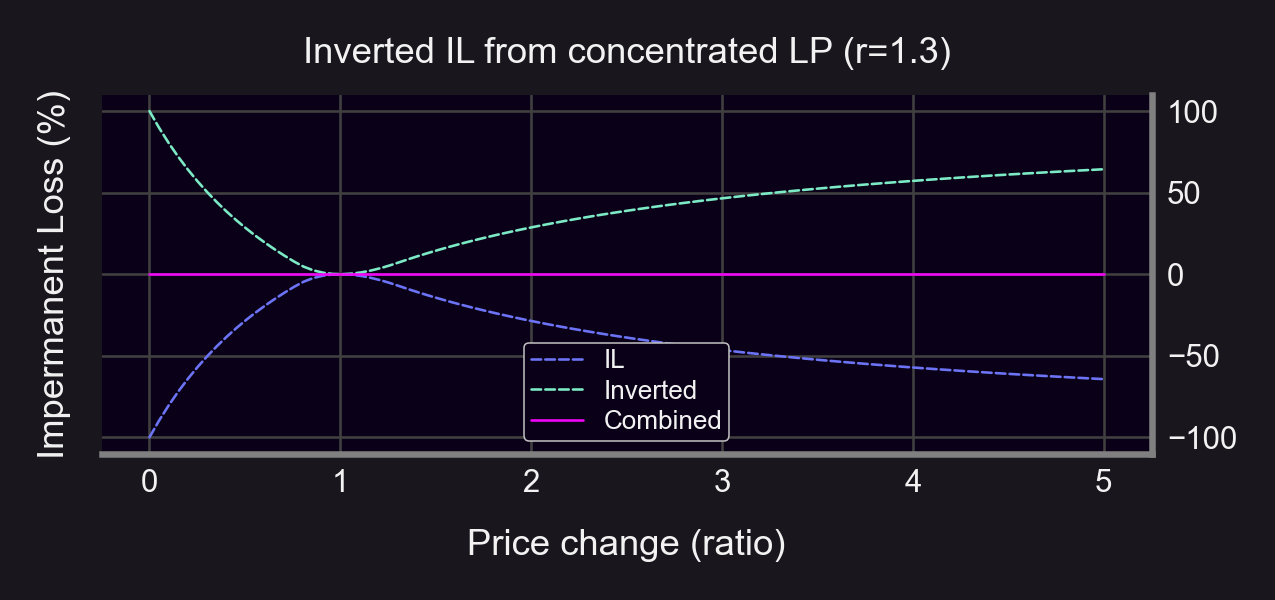

In [30]:
def inverted_curve(a: float, r: float) -> float:
    """    
    :a change-in-price ratio (a=2 means price doubled)
    :r range factor (r=1.3 means +/- 30% LP range)
    """
    if a < 1 / r:
        il = (np.sqrt(r) * a - 1) / (a + 1)
        il *= 100
    elif a < r:
        il = (np.sqrt(r) / (np.sqrt(r) - 1)) * IL_2(a)
    else:
        il = (np.sqrt(r) - a) / (a + 1)
        il *= 100
    return -il

a = list(np.linspace(0, 5, 100))

il = [IL_3(x, r) for x in a]
plt.plot(a, il, linestyle='--', label="IL")

inv_il = [inverted_curve(x, r) for x in a]
plt.plot(a, inv_il, linestyle='--', label="Inverted")

payoff = [x + y for x, y in zip(il, inv_il)]
plt.plot(a, payoff, label="Combined")

plt.xlabel('Price change (ratio)')
plt.ylabel('Impermanent Loss (%)')
plt.title(f"Inverted IL from concentrated LP (r={r})")
plt.legend(loc="lower center")

# Constructing a hedge

Try playing with different option parameters (S_0 = initial spot price, S = spot prices, X_c = strike price, P_c = option premium)!

In [25]:
# Call option
S_0 = 1_630
X_c = S_0 * r
P_c = 30

S = np.linspace(0, S_0 * 2.5, 100)

Text(0.5, 1.0, 'Long Call Option')

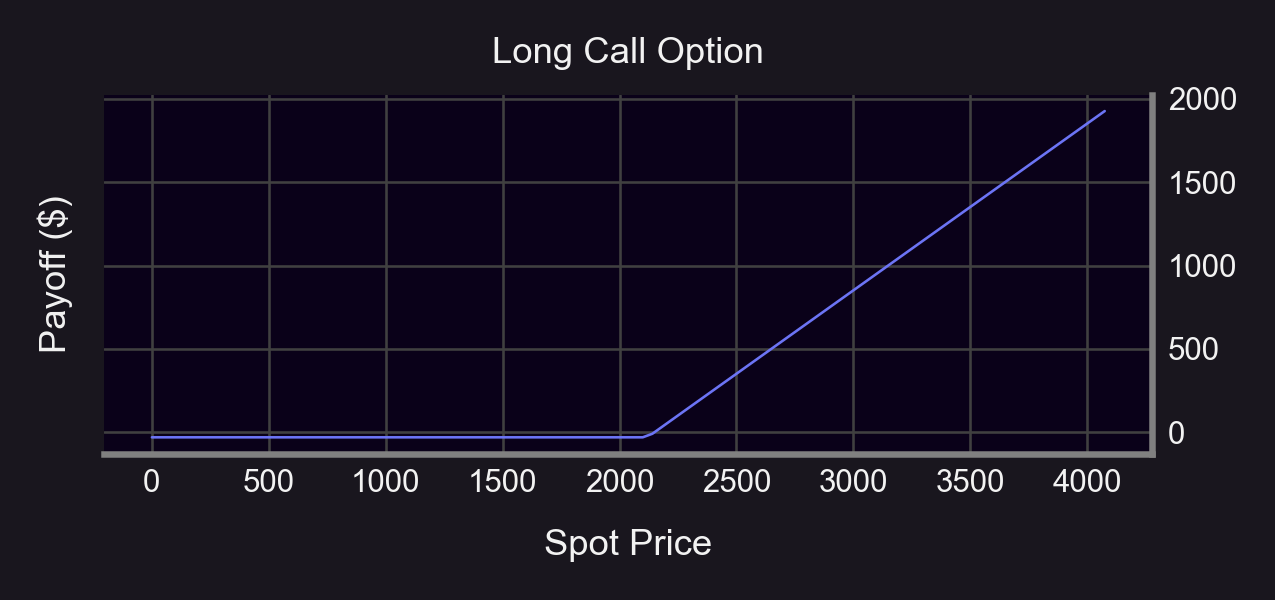

In [26]:
def call(S: np.ndarray, X: float, P: float) -> np.ndarray:
    """
    Calcaultes payoff for a call option

    :S Spot price
    :X Strike price
    :P Price (premium) of buying option
    """

    return np.where(S > X, S - X, 0) - P

payoff_call = call(S, X_c, P_c)

# Plot
plt.plot(S, payoff_call, label='Long Call')
plt.xlabel('Spot Price')
plt.ylabel('Payoff ($)')
plt.title('Long Call Option')

Try playing with different option parameters (S_0 = initial spot price, S = spot prices, X_p = strike price, P_p = option premium)!

In [27]:
# Put option
X_p = S_0 / r
P_p = 10

Text(0.5, 1.0, 'Long Put Option')

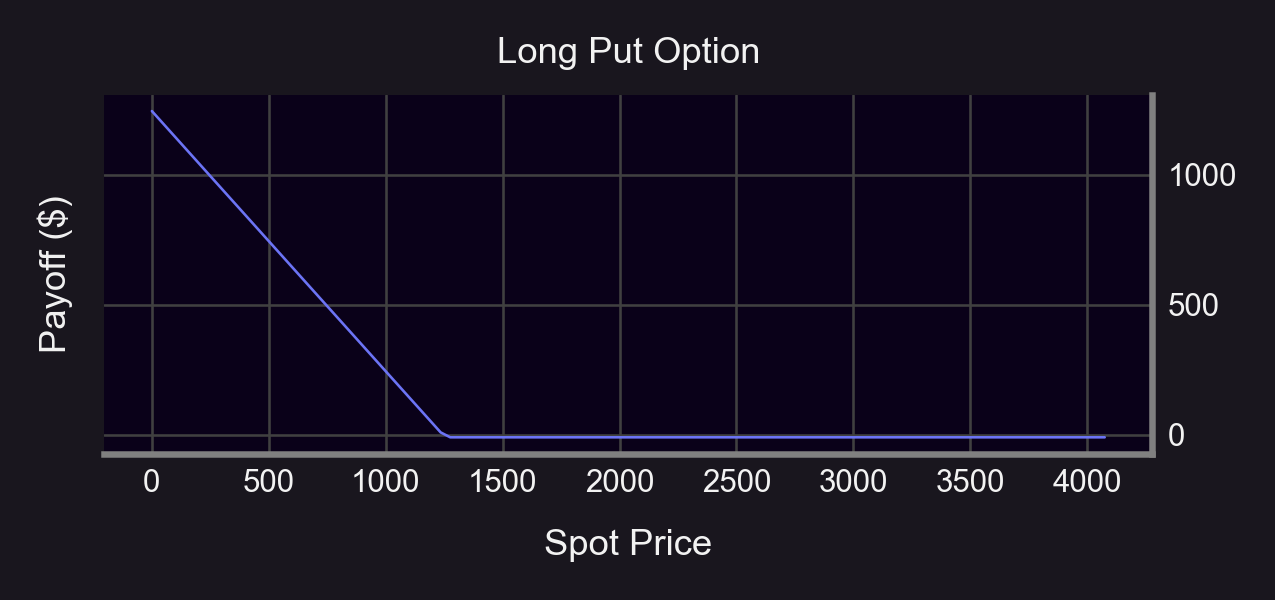

In [28]:
def put(S: np.ndarray, X: float, P: float) -> np.ndarray:
    """
    Calcaultes payoff for a call option

    :S Spot price
    :X Strike price
    :P Price (premium) of buying option
    """

    return np.where(S < X, X - S, 0) - P

payoff_put = put(S, X_p, P_p)

# Plot
plt.plot(S, payoff_put, label='Long Put')
plt.xlabel('Spot Price')
plt.ylabel('Payoff ($)')
plt.title('Long Put Option')

Text(0.5, 1.0, 'Long Strangle')

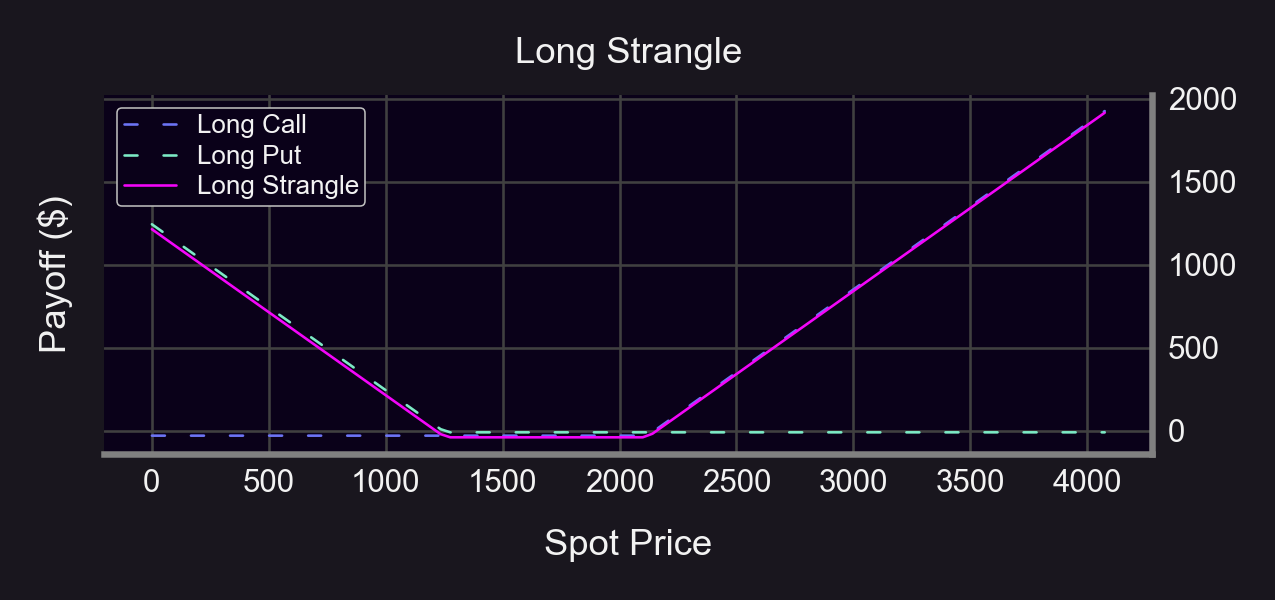

In [29]:
# Strangle
plt.plot(S, payoff_call, linestyle='--', dashes=(5, 10), label='Long Call')
plt.plot(S, payoff_put, linestyle='--', dashes=(5, 10), label='Long Put')
plt.plot(S, payoff_call + payoff_put, label='Long Strangle')
plt.xlabel('Spot Price')
plt.ylabel('Payoff ($)')
plt.legend()
plt.title('Long Strangle')

# Seeing how well our hedge does

In [33]:
def calc_hodl(
    S: float,
    S_0: float,
    capital_0: float,
    ) -> float:
    """
    Calculates HODL value in terms of token y
    
    :S current spot price
    :S_0 initial spot price
    :capital_0 initial capital in token y
    """

    # Split capital 50/50
    x_0 = (capital_0 / S_0) / 2
    y_0 = capital_0 / 2

    # HODL value
    hodl = x_0 * S + y_0
    return hodl

def calc_strangle(
    S: float,
    X_call: float,
    P_call: float,
    X_put: float,
    P_put: float
    ) -> float:
    """
    Calculates strangle value in terms of token y
    
    :S spot price
    :X_call call strike price
    :P_call call premium
    :X_put put strike price
    :P_put put premium
    """
    V_call = S - X_call if S > X_call else 0
    V_call -= P_call

    V_put = X_put - S if S < X_put else 0
    V_put -= P_put

    V = V_call + V_put
    return V

def calc_hedged_strangle_payoff(
    r: float = 1_000,
    S_0: float = 400,
    capital_0: float = 80_000,
    X_call: float = 520,
    P_call: float = 12,
    X_put: float = 280,
    P_put: float = 6,
    num_hedge_contracts: float = 100 
) -> None:
    '''Spot prices for x-axis, feel free to extend or shrink!'''
    spot_prices = np.linspace(0, S_0 * 5, 1000)

    # Calc price-change ratio
    a = [1 + ((S - S_0) / S_0) for S in spot_prices]
    il = [IL_3(x, r) for x in a] # as % of HODL value at price-change ratio 'a'
    hodl = [calc_hodl(S, S_0, capital_0) for S in spot_prices]
    hedge = [num_hedge_contracts * calc_strangle(S, X_call, P_call, X_put, P_put) for S in spot_prices]
    
    """
    il_LP (%) = 100 * (LP - HODL) / HODL
    il_LP_plus_hedge (%) = 100 * (LP + hedge - HODL) / HODL
                            = 100 * [(LP - HODL) / HODL + hedge / HODL]
                            = il_LP (%) + 100 * (hedge / HODL)
    """
    hedge_component = [100 * (x / y) for x, y in zip(hedge, hodl)]
    payoff = [x + y for x, y in zip(il, hedge_component)]
    plt.plot(a, il, linestyle='--', label="IL")
    plt.plot(a, hedge_component, linestyle='--', label="Hedge")
    plt.plot(a, payoff, label="IL when hedging")

    plt.xlabel('Price change (ratio)')
    plt.ylabel('Impermanent Loss (%)')
    plt.title(f"IL from concentrated LP with hedge (r={r})")
    plt.legend()

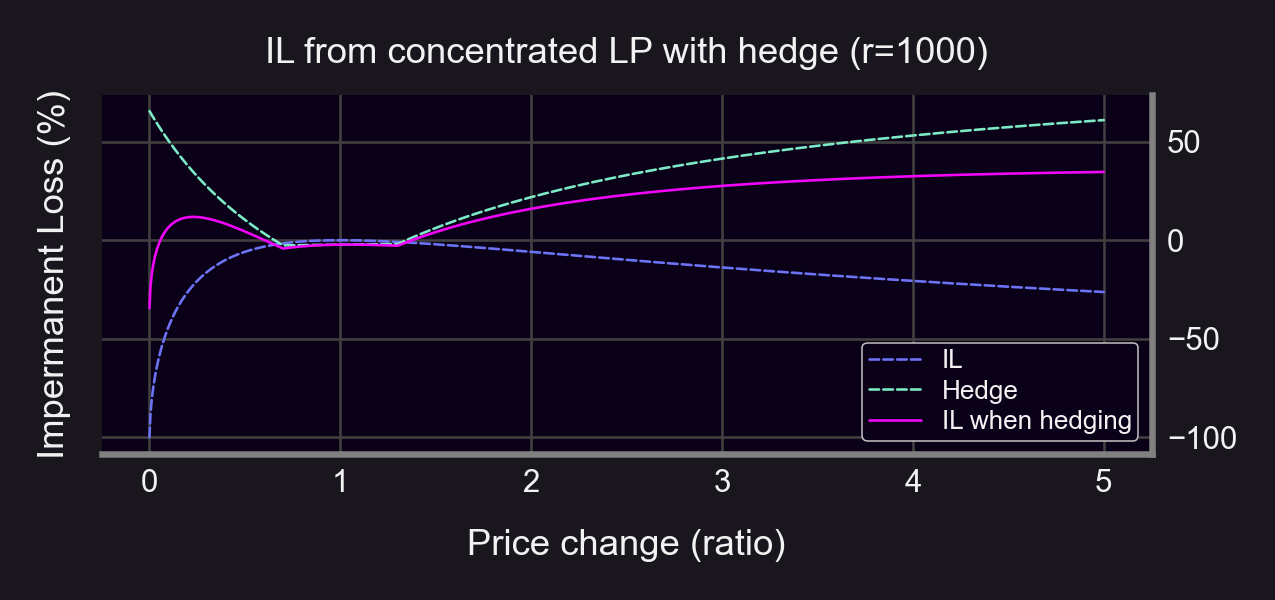

In [34]:
# Compare results to https://coinmarketcap.com/alexandria/article/hedging-against-impermanent-loss-a-deep-dive-with-finnexus-options
calc_hedged_strangle_payoff()

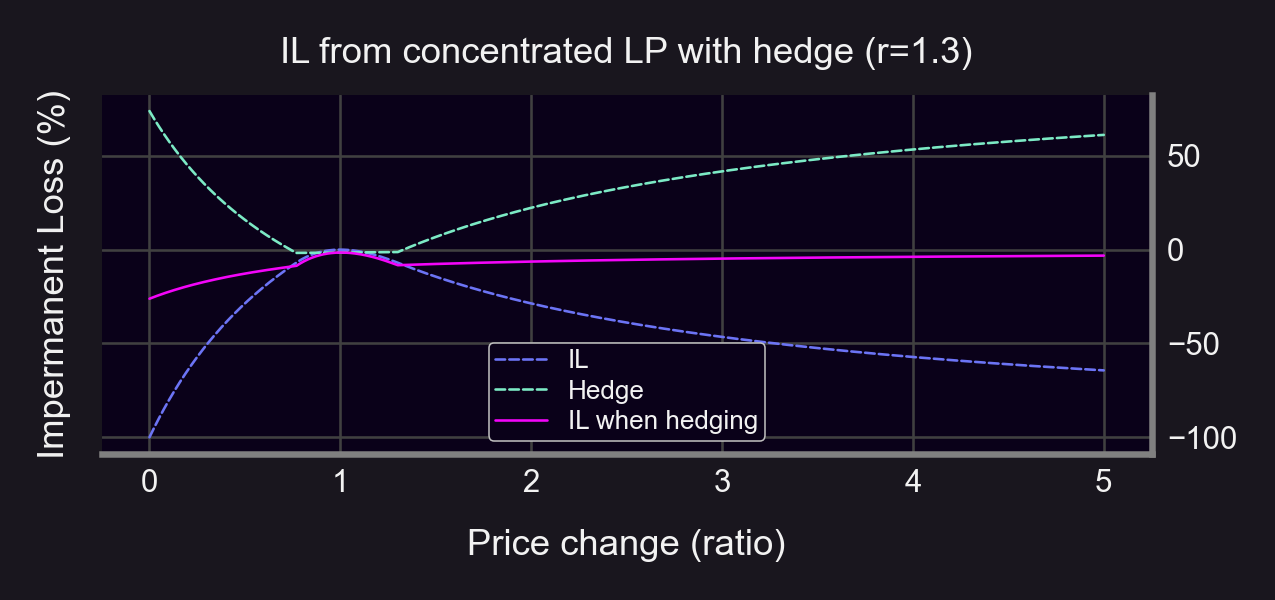

In [35]:
'''Strangle parameters - play around with them!'''
r = 1.3
S_0 = 1_630
capital_0 = S_0 * 2
X_call = S_0 * r
P_call = 25
X_put = S_0 / r
P_put = 25
num_hedge_contracts = 1

calc_hedged_strangle_payoff(
    r = r,
    S_0 = S_0,
    capital_0 = capital_0,
    X_call = X_call,
    P_call = P_call,
    X_put = X_put,
    P_put = P_put,
    num_hedge_contracts = num_hedge_contracts
)


# Can we do better?

In [36]:
def calc_option(
    option_type: str,
    S: float,
    X: float,
    P: float,
    ) -> float:
    """
    Calculates call value in terms of token y
    
    :contract_type "C' or 'P' (call or put)
    :S spot price
    :X strike price
    :P premium
    """
    if option_type.upper() == 'C':
        V = S - X if S > X else 0
    else:
        V = X - S if S < X else 0
    V -= P

    return V

def calc_hedged_payoff(
    r: float,
    S_0: float,
    capital_0: float,
    contracts: list[tuple] # [(C/P, X, P, num_contracts), ...]
) -> None:
    '''Spot prices for x-axis, feel free to extend or shrink!'''
    spot_prices = np.linspace(0, S_0 * 5, 1000)

    # Calc price-change ratio
    a = [1 + ((S - S_0) / S_0) for S in spot_prices]
    il = [IL_3(x, r) for x in a] # as % of HODL value at price-change ratio 'a'
    hodl = [calc_hodl(S, S_0, capital_0) for S in spot_prices]

    hedge = []
    for option_type, X, P, num_contracts in contracts:
        temp = [num_contracts * calc_option(option_type, S, X, P) for S in spot_prices]
        if hedge:
            hedge = [x + y for x, y in zip(hedge, temp)]
        else:
            hedge = temp
    
    """
    il_LP (%) = 100 * (LP - HODL) / HODL
    il_LP_plus_hedge (%) = 100 * (LP + hedge - HODL) / HODL
                            = 100 * [(LP - HODL) / HODL + hedge / HODL]
                            = il_LP (%) + 100 * (hedge / HODL)
    """
    hedge_component = [100 * (x / y) for x, y in zip(hedge, hodl)]
    payoff = [x + y for x, y in zip(il, hedge_component)]
    plt.plot(a, il, linestyle='--', label="IL")
    plt.plot(a, hedge_component, linestyle='--', label="Hedge")
    plt.plot(a, payoff, label="IL when hedging")

    plt.xlabel('Price change (ratio)')
    plt.ylabel('Impermanent Loss (%)')
    plt.title(f"IL from concentrated LP with hedge (1 call, 1.25 puts, r={r})")
    plt.legend(loc="lower center")

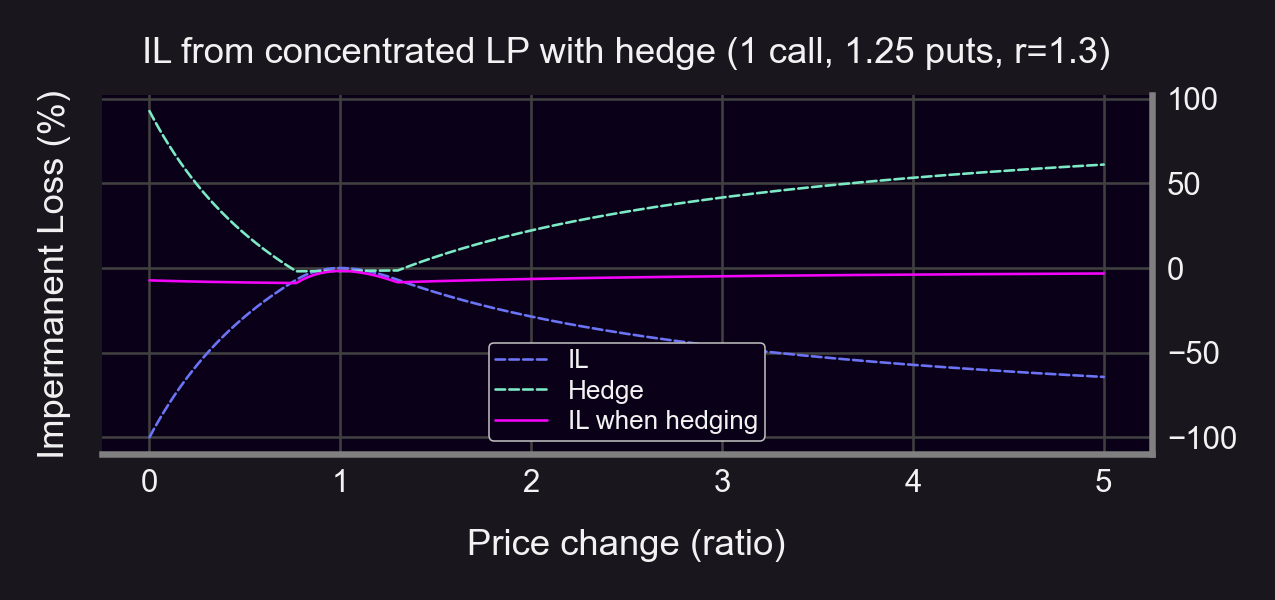

In [37]:
'''Hedge parameters - play around with them!'''
r = 1.3
S_0 = 1_630
capital_0 = S_0 * 2
X_call = S_0 * r
P_call = 25
X_put = S_0 / r
P_put = 25
num_calls = 1
num_puts = 1.25

contracts = [('C', X_call, P_call, num_calls), ('P', X_put, P_put, num_puts)]

calc_hedged_payoff(
    r = r,
    S_0 = S_0,
    capital_0 = capital_0,
    contracts = contracts
)